In [ ]:
pip install neat-python

     |████████████████████████████████| 51kB 2.4MB/s 


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/NEAT

/content/drive/MyDrive/Colab Notebooks/NEAT


In [ ]:
  MINUTES_IN_DAY = 1440

In [ ]:
from scipy.stats import binom
import random
import numpy as np
 
def get_distributed_participants_for_one_day(number_of_participants):
  response = [0] * MINUTES_IN_DAY
 
  distribution = binom.rvs(n=1440,p=0.85,size=number_of_participants)
  for minute in range(MINUTES_IN_DAY):
    response[minute] = np.count_nonzero(distribution == minute)    
    if response[minute] == 0:
      response[minute] = random.randint(0, 4)
 
  return response

In [ ]:
"""
A parallel version of XOR using neat.parallel.
 
Since XOR is a simple experiment, a parallel version probably won't run any
faster than the single-process version, due to the overhead of
inter-process communication.
 
If your evaluation function is what's taking up most of your processing time
(and you should check by using a profiler while running single-process),
you should see a significant performance improvement by evaluating in parallel.
 
This example is only intended to show how to do a parallel experiment
in neat-python.  You can of course roll your own parallelism mechanism
or inherit from ParallelEvaluator if you need to do something more complicated.
"""
 
from __future__ import print_function
 
import gzip
import math
import os
import pickle
import time
import matplotlib.pyplot as plt
import numpy as np 
import regex as re
import random
 
import neat
 
import visualize
 
def get_percentage(current_amount, total_amount):
  if total_amount == 0:
    return 100
 
  return (current_amount * 100) / total_amount  
 
def get_area_reward(time_left_in_percent, prices_left_in_percent):
    prices_won_in_percent = 100.0 - prices_left_in_percent
 
    no_multiplier = 0.2
    reward_multiplier = 2000
 
    if time_left_in_percent <= 100.0 and time_left_in_percent >= 90.0:
      if prices_left_in_percent >= 99.0:
        return no_multiplier
 
      if prices_left_in_percent <= 94.2:
        return no_multiplier
 
      return reward_multiplier
 
 
    if time_left_in_percent <= 92.0 and time_left_in_percent >= 88.2:
      if prices_left_in_percent >= 95.0:
        return no_multiplier
 
      if prices_left_in_percent <= 93.2:
        return no_multiplier
 
      return reward_multiplier
 
    if time_left_in_percent <= 75.0 and time_left_in_percent >= 73.2:
      if prices_left_in_percent >= 60.0:
        return no_multiplier
 
      if prices_left_in_percent <= 55.2:
        return no_multiplier
 
      return reward_multiplier
 
    if time_left_in_percent <= 56.0 and time_left_in_percent >= 49.5:
      if prices_left_in_percent >= 50.9:
        return no_multiplier
 
      if prices_left_in_percent <= 48.6:
        return no_multiplier
 
      return reward_multiplier
      
    if time_left_in_percent <= 39.5 and time_left_in_percent >= 42.0:
      if prices_left_in_percent >= 40.3:
        return no_multiplier
 
      if prices_left_in_percent <= 37.2:
        return no_multiplier
 
      return reward_multiplier
 
    if time_left_in_percent <= 26.3 and time_left_in_percent >= 24.0:
      if prices_left_in_percent >= 30.3:
        return no_multiplier
 
      if prices_left_in_percent <= 20.2:
        return no_multiplier      
 
      return reward_multiplier
 
    if time_left_in_percent <= 10.5 and time_left_in_percent >= 8.0:
      if prices_left_in_percent >= 15.1:
        return no_multiplier
 
      if prices_left_in_percent <= 11.8:
        return no_multiplier
 
      return reward_multiplier
 
    if time_left_in_percent <= 4.25 and time_left_in_percent >= 2.0:
      if prices_left_in_percent <= 8.1:
        return no_multiplier
 
      if prices_left_in_percent > 5.5:
        return no_multiplier      
 
      return reward_multiplier
 
    if time_left_in_percent <= 2.0 and time_left_in_percent >= 0.0:
      if prices_left_in_percent <= 2.5:
        return no_multiplier              
 
      if prices_left_in_percent > 0.3:
        return no_multiplier      
 
      return reward_multiplier
 
    return no_multiplier
  
def get_price_distribution_reward(price_distribution):
    base_multiplier = 0.5
 
    if len(price_distribution) < 3:
      return 0
 
    prices_won_in_percent = get_percentage(np.count_nonzero(price_distribution), len(price_distribution))
    if prices_won_in_percent <= 15.0 or prices_won_in_percent >= 45.0:
      return 0
 
    return (45 - (prices_won_in_percent - 15.0)) * 40
 
 
def eval_genome(genome, config):
    """
    This function will be run in parallel by ParallelEvaluator.  It takes two
    arguments (a single genome and the genome class configuration data) and
    should return one float (that genome's fitness).
 
    Note that this function needs to be in module scope for multiprocessing.Pool
    (which is what ParallelEvaluator uses) to find it.  Because of this, make
    sure you check for __main__ before executing any code (as we do here in the
    last few lines in the file), otherwise you'll have made a fork bomb
    instead of a neuroevolution demo. :)
    """
 
    net = neat.nn.FeedForwardNetwork.create(genome, config)
 
    TOTAL_TRAINING_PRICES = random.randint(TOTAL_PRICES_FROM, TOTAL_PRICES_TO)
    TOTAL_TRAINING_TIME = random.randint(TOTAL_TIME_FROM, TOTAL_TIME_TO)
 
    time_left = TOTAL_TRAINING_TIME
    prices_left = TOTAL_TRAINING_PRICES
    price_distribution = []
 
    current_time_left_in_percent = 100
    last_time_in_percent_with_prices_left = 0
    fitness = 0.0
    minute_of_day = 0
    distributed_participants = []
    next_time_left_in_percent = 0
    prices_left_in_percent = 100
    time_left_in_percent = 100
    time_passed_in_percent = 0  
 
    while time_left > 0:
      if minute_of_day == 0:
        distributed_participants = get_distributed_participants_for_one_day(random.randint(TOTAL_PARTICIPANTS_FROM, TOTAL_PARTICIPANTS_TO))
 
      time_left -= 1
 
      for participants in range(distributed_participants[minute_of_day]):
        prices_left_in_percent = get_percentage(prices_left, TOTAL_TRAINING_PRICES)
        time_left_in_percent = get_percentage(time_left, TOTAL_TRAINING_TIME)
        next_time_left_in_percent = math.floor(time_left_in_percent)
        time_passed_in_percent = 100 - time_left_in_percent
 
        output = net.activate((
          time_passed_in_percent / 100, 
          prices_left_in_percent / 100,
          get_percentage(np.count_nonzero(price_distribution), len(price_distribution)) / 100
        ))
  
        give_out_price = output[0] > 0.5
  
        if len(price_distribution) == 35:
          del price_distribution[0]
  
        price_distribution.append(1 if give_out_price else 0)
  
        prices_left -= (1 if give_out_price else 0)
        if prices_left < 0:
          prices_left = 0
  
        prices_left_in_percent = get_percentage(prices_left, TOTAL_TRAINING_PRICES)
 
 
              
      if not current_time_left_in_percent == next_time_left_in_percent:
        if prices_left_in_percent > 0.0:
          last_time_in_percent_with_prices_left = 100 - time_left_in_percent
 
        fitness += (
            get_area_reward(time_left_in_percent, prices_left_in_percent)
            #get_price_distribution_reward(price_distribution)
        ) * 30
 
      current_time_left_in_percent = next_time_left_in_percent
 
      minute_of_day += 1
      minute_of_day = 0 if minute_of_day == MINUTES_IN_DAY else minute_of_day
 
 
    fitness += (
        ((100 - prices_left_in_percent) * 110) +
        (last_time_in_percent_with_prices_left * 100)
    ) * 1200    
 
    return fitness
 
def save_winner_net(winner_net, generation):
    with gzip.open('winner-net-' + str(generation), 'w', compresslevel=5) as f:
      pickle.dump(winner_net, f, protocol=pickle.HIGHEST_PROTOCOL)
 
def evolute_for_x_generations(
    config, 
    population, 
    parallel_evolutor, 
    stats, 
    number_of_generations,
    current_generation
):
    winner = population.run(parallel_evolutor.evaluate, number_of_generations)
 
    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))
 
    # Show output of the most fit genome against training data.
    print('\nOutput:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
 
    time_left = TOTAL_TIME
    prices_left = TOTAL_PRICES
 
    time_passed_history = []
    prices_left_history = []
    price_distribution = []
    minute_of_day = 0
    distributed_participants = []
    prices_left_in_percent = 100
    time_left_in_percent = 100
    time_passed_in_percent = 0
 
    while time_left >= 0:
      if minute_of_day == 0:
        distributed_participants = get_distributed_participants_for_one_day(random.randint(TOTAL_PARTICIPANTS_FROM, TOTAL_PARTICIPANTS_TO))
 
      time_left -= 1
 
      for participants in range(distributed_participants[minute_of_day]):
        prices_left_in_percent = get_percentage(prices_left, TOTAL_PRICES)
        time_left_in_percent = get_percentage(time_left, TOTAL_TIME)
        time_passed_in_percent = 100 - time_left_in_percent
  
        output = winner_net.activate((
          time_passed_in_percent / 100, 
          prices_left_in_percent / 100,
          get_percentage(np.count_nonzero(price_distribution), len(price_distribution)) / 100
        ))
  
        give_out_price = output[0] > 0.5
        if len(price_distribution) == 35:
          del price_distribution[0]
  
        price_distribution.append(1 if give_out_price else 0)
  
        prices_left -= (1 if give_out_price else 0)
        if prices_left < 0:
          prices_left = 0
  
        prices_left_in_percent = get_percentage(prices_left, TOTAL_PRICES)
 
 
      time_passed_history.append(time_passed_in_percent)
      prices_left_history.append(prices_left)
 
      minute_of_day += 1
      minute_of_day = 0 if minute_of_day == MINUTES_IN_DAY else minute_of_day
 
 
    node_names = {-1: 'time_passed', -2: 'prices_left', -3: 'price_distribution', 0:'give out price'}
    visualize.draw_net(config, winner, True, node_names = node_names)
    #visualize.plot_stats(stats, ylog=False, view=True)
    #visualize.plot_species(stats, view=True)
 
   
    print('total prices:')
    print(TOTAL_PRICES)
 
    print('prices left:')
    print(prices_left)
 
    generation = current_generation + len(stats.most_fit_genomes) + 1
    handle, = plt.plot(time_passed_history, prices_left_history, Label = generation)
    save_winner_net(winner_net, generation)
 
    return handle
 
def run(config_file, checkpoint_generation): 
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
 
    # Create the population, which is the top-level object for a NEAT run.
    if not checkpoint_generation is None:
      p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-' + str(checkpoint_generation))
 
      for f in os.listdir('.'):
        if re.search('neat-checkpoint', f) and not re.search('-' + str(checkpoint_generation), f):
          os.remove(os.path.join('.', f))
        if re.search('winner-net', f) and not re.search('-' + str(checkpoint_generation), f):
          os.remove(os.path.join('.', f))
 
    else:
      p = neat.Population(config)
 
    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(10))
 
    plot_handles = []
    pe = neat.ParallelEvaluator(60, eval_genome)
    for x in range(11):
 
      plot_handles.append(evolute_for_x_generations(
          config, 
          p, 
          pe, 
          stats, 
          10,
          0 if not checkpoint_generation else checkpoint_generation
      ))
 
    plt.legend(handles=plot_handles)

Streaming output truncated to the last 5000 lines.
	74183 DefaultNodeGene(key=74183, bias=0.8050921343235418, response=1.0, activation=tanh, aggregation=sum)
	75327 DefaultNodeGene(key=75327, bias=-0.1460608278712423, response=1.0, activation=tanh, aggregation=sum)
	76013 DefaultNodeGene(key=76013, bias=0.6682391963926916, response=1.0, activation=tanh, aggregation=sum)
	78341 DefaultNodeGene(key=78341, bias=1.2315502125702604, response=1.0, activation=tanh, aggregation=sum)
	81191 DefaultNodeGene(key=81191, bias=-0.9612951693164455, response=1.0, activation=tanh, aggregation=sum)
	85497 DefaultNodeGene(key=85497, bias=0.04900776202382594, response=1.0, activation=tanh, aggregation=sum)
	94146 DefaultNodeGene(key=94146, bias=-1.7310565785268626, response=1.0, activation=tanh, aggregation=sum)
	96424 DefaultNodeGene(key=96424, bias=0.26344068009252786, response=1.0, activation=tanh, aggregation=sum)
	110463 DefaultNodeGene(key=110463, bias=-2.486686031650171, response=1.0, activation=ta

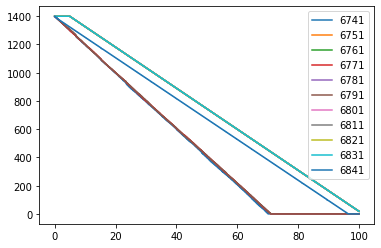

In [ ]:
if __name__ == '__main__': 
    TOTAL_PARTICIPANTS_FROM = 20
    TOTAL_PARTICIPANTS_TO = 250
    TOTAL_TIME = 17460
    TOTAL_TIME_FROM = 8500
    TOTAL_TIME_TO = 17460
    TOTAL_PRICES = 1400
    TOTAL_PRICES_FROM = 1100
    TOTAL_PRICES_TO = 1400
 
    # Determine path to configuration file. This path manipulation is
    # here so that the script will run successfully regardless of the
    # current working directory.
    local_dir = os.path.dirname(os.path.abspath("__file__"))
    config_path = os.path.join(local_dir, 'config-feedforward')
    run(config_path, 6416)

In [ ]:
 
import gzip
import pickle
import neat
import os
import random
 
def load_winner_net(filename):
    with gzip.open(filename) as f:
        obj = pickle.load(f)
        return obj
 
def run_test(
    winner_net_file, 
    total_time, 
    total_prices, 
    number_of_participants_from,
    number_of_participants_to
  ):
    winner_net = load_winner_net(winner_net_file)
 
    time_left = total_time
    prices_left = total_prices
    time_passed_history = []
    prices_left_history = []    
    price_distribution = []
 
    minute_of_day = 0
    distributed_participants = []
 
    while time_left >= 0:
      if minute_of_day == 0:
        distributed_participants = get_distributed_participants_for_one_day(random.randint(number_of_participants_from, number_of_participants_to))
 
      time_left -= 1
 
      prices_left_in_percent = get_percentage(prices_left, total_prices)
      time_left_in_percent = get_percentage(time_left, total_time)
      time_passed_in_percent = 100 - time_left_in_percent
      
      give_out_price = False
      for participants in range(distributed_participants[minute_of_day]):
        output = winner_net.activate((
          time_passed_in_percent / 100, 
          prices_left_in_percent / 100,
          get_percentage(np.count_nonzero(price_distribution), len(price_distribution)) / 100
        ))
  
        give_out_price = output[0] > 0.5
        price_distribution.append(1 if give_out_price else 0)
        if len(price_distribution) == 35:
          del price_distribution[0]
            
        prices_left -= (1 if give_out_price else 0)
        if prices_left < 0:
          prices_left = 0
 
        prices_left_in_percent = get_percentage(prices_left, total_prices)
 
 
      time_passed_history.append(time_passed_in_percent)
      prices_left_history.append(prices_left)
 
      if distributed_participants[minute_of_day] == 0:
        plt.plot([time_passed_in_percent], [1], 'r+')      
 
      minute_of_day += 1
      minute_of_day = 0 if minute_of_day == MINUTES_IN_DAY else minute_of_day
 
      if time_left % 1000 == 0:
        print('time left: ')
        print(time_left)
 
        print('prices left: ')
        print(prices_left)
 
 
    print('prices left: ')
    print(prices_left)
 
    
    handle, = plt.plot(time_passed_history, prices_left_history)

time left: 
57000
prices left: 
21866
time left: 
56000
prices left: 
21454
time left: 
55000
prices left: 
21294
time left: 
54000
prices left: 
20975
time left: 
53000
prices left: 
20527
time left: 
52000
prices left: 
20308
time left: 
51000
prices left: 
19812
time left: 
50000
prices left: 
19249
time left: 
49000
prices left: 
19047
time left: 
48000
prices left: 
18700
time left: 
47000
prices left: 
18180
time left: 
46000
prices left: 
17633
time left: 
45000
prices left: 
17441
time left: 
44000
prices left: 
16932
time left: 
43000
prices left: 
16439
time left: 
42000
prices left: 
16253
time left: 
41000
prices left: 
15762
time left: 
40000
prices left: 
15437
time left: 
39000
prices left: 
15203
time left: 
38000
prices left: 
14783
time left: 
37000
prices left: 
14248
time left: 
36000
prices left: 
13851
time left: 
35000
prices left: 
13609
time left: 
34000
prices left: 
13066
time left: 
33000
prices left: 
12528
time left: 
32000
prices left: 
12327
time left: 


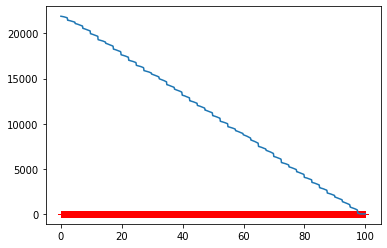

In [ ]:
# Determine path to configuration file. This path manipulation is
# here so that the script will run successfully regardless of the
# current working directory.
 
TOTAL_TIME = 57400
TOTAL_PRICES = 21911
 
run_test('winner-net-6841', TOTAL_TIME, TOTAL_PRICES, 1200, 4000)